# Zillow_clustering_Project: Understanding and Improving Zestimate

Glady Barrios

AUG, 9, 2022

Kalpana Cohort

## Project Goal

- Use clustering algorithms to determine driving errors in the current Zestimate.
- Trying to find and use the differnt drivers of logerror to improve the Zestimate Model.

## Project Description

The goal of this project is to find the driving errors in the Zestimate and find ways to better improve Zillows current models. Improving our models will help zillow customers get more accurate home prices. We want our customers to have the most accurate information when looking for a home. In order to accomplish this we will go through the data science pipeling of aquiring,preparing,exploring and modeling the data and using our ML models to accomplish this 



### Log Error = log(Zestimate) - log(Sale Price)

In [1]:
#important libraries needed for this report
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing


from wrangle import wrangle_zillow
from prepare import train_validate_test_split, scale_data

from scipy import stats
from math import sqrt

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Wrangle the data

_Data Acquisition_
- I aquired the data from Codeup SQL Database
- More information on my [Wrangle Page](https://github.com/GladyBarrios/Zillow_clustering_Project/blob/main/explore_and_model_zillow.ipynb)
- I only aquired data from `2017 properties` and `single families homes`, filtered by `single family recidential` 

### How I Wrangled the Data 
- Kept the collums that have 60% of their data (since there was many nulls)
    - removed columns that have 30% of data missing 
- Kept the rows that have 75% of their data
    - removed rows that have 15% of data missing
- For some collumns I decided to fill some of the nulls with the mean of the column such as `lotsizesquarefeet`, `taxvaluedollarcount`, `yearbuilt` 

Columns I added:

- 'County'- displaying the names of the three difrent counties 
- 'age' calculated by 2017 -the year it was built
- 'acres' was calculated by lotsizesquarefeet divided by 43560 
- Added dummy variables for counties 

Removing outliers:
- More than 7 bathrroms and bedrooms
- Removed 0 bed and bath 
- Any acres greater than 20 


For more information plase visit my Git Hub Repo or [Click Here](https://github.com/GladyBarrios/Zillow_clustering_Project/blob/main/wrangle.py)

In [2]:
df = wrangle_zillow()
df.head(3)

,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,...,transactiondate,propertylandusedesc,County,age,age_bin,acres,acres_bin,LA,Orange,Ventura
0,1727539,14297519,3.5,4.0,6059.0,33634931.0,-117869207.0,4506.0,122,261.0,...,2017-01-01,Single Family Residential,Orange County,19.0,0.133,0.103444,0.1,0,1,0
1,1387261,17052889,1.0,2.0,6111.0,34449266.0,-119281531.0,12647.0,1110,261.0,...,2017-01-01,Single Family Residential,Ventura County,50.0,0.333,0.290335,0.3,0,0,1
2,11677,14186244,2.0,3.0,6059.0,33886168.0,-117823170.0,8432.0,122,261.0,...,2017-01-01,Single Family Residential,Orange County,55.0,0.400,0.193572,0.2,0,1,0


### Splitting the data 

In [3]:
train, validate, test = train_validate_test_split(df)
train.shape, validate.shape, test.shape

((29136, 26), (12488, 26), (10406, 26))

### Scaling the data 

In [4]:
train_s, valid_s, test_s = scale_data(train, validate, test)


In [5]:
train_s.head(1)

,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,...,transactiondate,propertylandusedesc,County,age,age_bin,acres,acres_bin,LA,Orange,Ventura
34264,2036202,12529787,0.5,0.5,6037.0,0.290645,0.705217,0.008265,0101,261.0,...,2017-06-27,Single Family Residential,Los Angeles County,52.0,0.4,0.150826,0.2,1,0,0


<hr style="border:2px solid green">

# Exploring the data 

Exploration Questions asked 
- Question 1 - Is log error significantly different for properties in the three counties?
- Question 2 - Is log error significantly different for properties that have diffrent bathroom counts?
- Question 3 - Is log error significantly different for properties that have diffrent bedroom counts?
- Question 4 - Is log error significantly different for properties that have diffrent proprty values?

## Question 1 - Is log error significantly different for properties in the three counties?

$H_0$: Log error will be the same across all three counties

$H_a$: Log error will vary based on county

<AxesSubplot:xlabel='County', ylabel='logerror'>

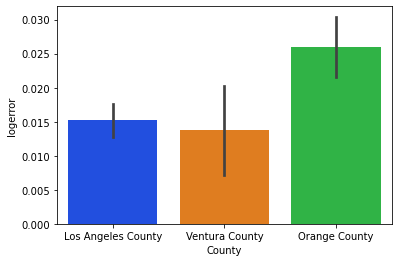

In [6]:
#Compare the average log error between counties
sns.barplot(x='County', y='logerror', data=train, palette= "bright")

In [7]:
#Conduct an ANOVA test between the counties
f_county, p_county = stats.f_oneway(df[df['County'] == 'Los Angeles County'].logerror,
                                    df[df['County'] == 'Orange County'].logerror,
                                    df[df['County'] == 'Ventura County'].logerror)

f_county, p_county

(22.500550909641934, 1.7074916354433785e-10)

In [8]:
#Compare my p value to alpha
alpha = 0.05
if p_county < alpha:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis.


Takeaways

- looks like log error is varied by the county based on the visualization and statistical anova test 

<hr style="border:2px solid gray">

## Question 2 - Is log error significantly different for properties that have diffrent bathroom counts 

<AxesSubplot:xlabel='bathroomcnt', ylabel='logerror'>

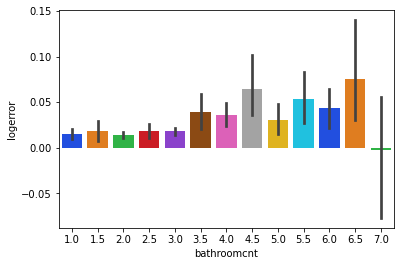

In [9]:
sns.barplot(x='bathroomcnt', y='logerror', data=train, palette= "bright")

Takeaways 
- As the bathroom count increases we can see that logerror increases 

<hr style="border:2px solid gray">

## Question 3 - Is log error significantly different for properties that have diffrent bedroom counts

<AxesSubplot:xlabel='bedroomcnt', ylabel='logerror'>

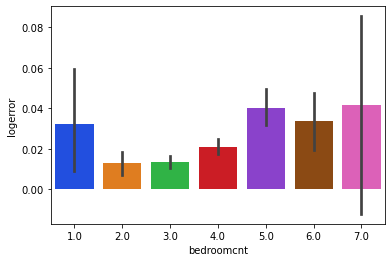

In [11]:
sns.barplot(x='bedroomcnt', y='logerror', data=train, palette= "bright")

Takeaways 
- As the bedroom count increases we can see that logerror increases 

<hr style="border:2px solid gray">

## Question 4 -  Is log error significantly different for properties that have diffrent property values

<AxesSubplot:xlabel='taxvaluedollarcnt', ylabel='logerror'>

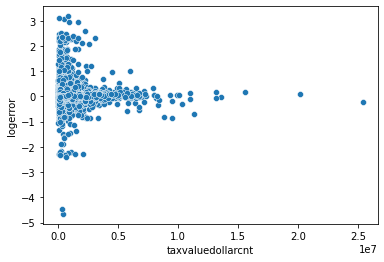

In [12]:
sns.scatterplot(x='taxvaluedollarcnt', y='logerror', data=train, palette= "bright")

Null hypothesis: There is no correlation between price and log error.
    
Alternative hypothesis: There is a relationship between price and log error.

In [13]:
#Test for correlation between the two
corr_value, p_value = stats.pearsonr(df['taxvaluedollarcnt'],
                                     df['logerror'])

corr_value, p_value

(-0.006149787116911295, 0.16069102565002474)

In [14]:
#Test my hypothesis
if p_value < alpha:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

We fail to reject the null hypothesis.


Takeaways

- There is no correlation between price and log error 

--------------

### Exploration Takeaways
 - there is a diffrence in logerror between the diffrent counties 
 - There is no correlation between price and logerror 
 - As the bathroom count increases we can see that logerror increases 
 - As the bedroom count increases we can see that logerror increases 

<hr style="border:2px solid green">

# Clustering

- Used K-means Clustering Method 
- Choose K using the elbow method (using innertia)
- To look at the elbow method visualiation please look at my GitHub repo or  [Click Here](https://github.com/GladyBarrios/Zillow_clustering_Project/blob/main/wrangle.py)


### Clusters
- `Size_Cluster` , contains features: `bathroomcnt , bedroomcnt, lotsizesquarefeet`
- `Location_Cluster`, contains features: `latitude, longitude`
- `Age_size`, contains features: `age, lotsize`

## First cluster 

"Size Cluster" that contains the features: bathroomcnt , bedroomcnt, lotsizesquarefeet

In [15]:
X = train_s[['bathroomcnt', 'bedroomcnt','lotsizesquarefeet']]
X.head()

,bathroomcnt,bedroomcnt,lotsizesquarefeet
34264,0.500000,0.500000,0.008265
8237,0.166667,0.166667,0.014113
31640,0.166667,0.333333,0.019604
14309,0.166667,0.333333,0.009377
50710,0.500000,0.333333,0.212281


In [16]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

clusters = kmeans.predict(X)
clusters

array([0, 2, 1, ..., 1, 3, 1], dtype=int32)

In [17]:
train_s['size_cluster'] = clusters

In [18]:
kmeans.cluster_centers_

array([[0.58584956, 0.59164349, 0.0237971 ],
       [0.20636963, 0.32878897, 0.01143319],
       [0.03791556, 0.20881142, 0.01000254],
       [0.25686106, 0.52542405, 0.01271542]])

In [19]:
centroids2 = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

Text(0.5, 1.0, 'Visualizing Cluster Centers')

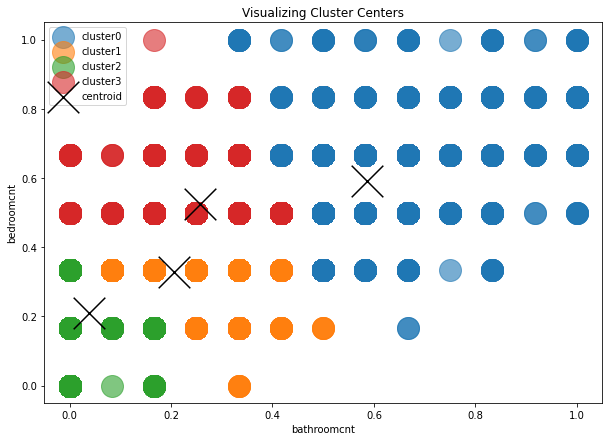

In [20]:
plt.figure(figsize=(10, 7))

for cluster, subset in train_s.groupby('size_cluster'):
    plt.scatter(subset.bathroomcnt, subset.bedroomcnt, label='cluster' + str(cluster), alpha=.6, s=22**2)

centroids2.plot.scatter(y='bedroomcnt', x='bathroomcnt', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('bathroomcnt')
plt.ylabel('bedroomcnt')
plt.title('Visualizing Cluster Centers')


_Test for size_cluster relate to log error_
- Using a correlation test
 - $H_0$: There is not a linear relationship between size_cluster and logerror
 - $H_a$: There is a linear relationship between size_cluster and logerror

In [21]:
x = train_s.size_cluster
y = train_s.logerror
α = 0.05
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)
if p < α:
    print("We reject the H0.")
else:
    print("We fail to reject the H0.")

r = -0.010315642888190158
p = 0.0782762723441327
We fail to reject the H0.


#### Takeaways


- There is no linear correlation between size_cluster and logerror

<hr style="border:2px solid gray">

## Second Cluster 
- "location_cluster" contains features: 'latitude','longitude'

In [22]:
L = train_s[['latitude', 'longitude']]
L.head()

,latitude,longitude
34264,0.290645,0.705217
8237,0.477749,0.697542
31640,0.559977,0.271079
14309,0.559026,0.279767
50710,0.688996,0.084830


In [23]:
kmeans1 = KMeans(n_clusters=4)
kmeans1.fit(L)

clusters = kmeans1.predict(L)
clusters

array([1, 1, 0, ..., 3, 0, 2], dtype=int32)

In [24]:
train_s['location_cluster'] = clusters
train_s.head()

,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,...,County,age,age_bin,acres,acres_bin,LA,Orange,Ventura,size_cluster,location_cluster
34264,2036202,12529787,0.500000,0.500000,6037.0,0.290645,0.705217,0.008265,0101,261.0,...,Los Angeles County,52.0,0.400,0.150826,0.2,1,0,0,0,1
8237,2883002,11848044,0.166667,0.166667,6037.0,0.477749,0.697542,0.014113,0101,261.0,...,Los Angeles County,65.0,0.466,0.253696,0.3,1,0,0,2,1
31640,2759592,17271234,0.166667,0.333333,6111.0,0.559977,0.271079,0.019604,1111,261.0,...,Ventura County,33.0,0.266,0.350298,0.3,0,0,1,1,0
14309,1044874,17266806,0.166667,0.333333,6111.0,0.559026,0.279767,0.009377,1111,261.0,...,Ventura County,46.0,0.333,0.170386,0.2,0,0,1,1,0
50710,2848400,17068575,0.500000,0.333333,6111.0,0.688996,0.084830,0.212281,1110,261.0,...,Ventura County,28.0,0.200,3.739991,0.5,0,0,1,0,0


In [25]:
kmeans1.cluster_centers_


array([[0.60702889, 0.4152443 ],
       [0.43851585, 0.68929205],
       [0.24033455, 0.8647349 ],
       [0.86700503, 0.7004039 ]])

In [26]:
centroids = pd.DataFrame(kmeans1.cluster_centers_, columns=L.columns)


Text(0.5, 1.0, 'Visualizing Cluster Centers')

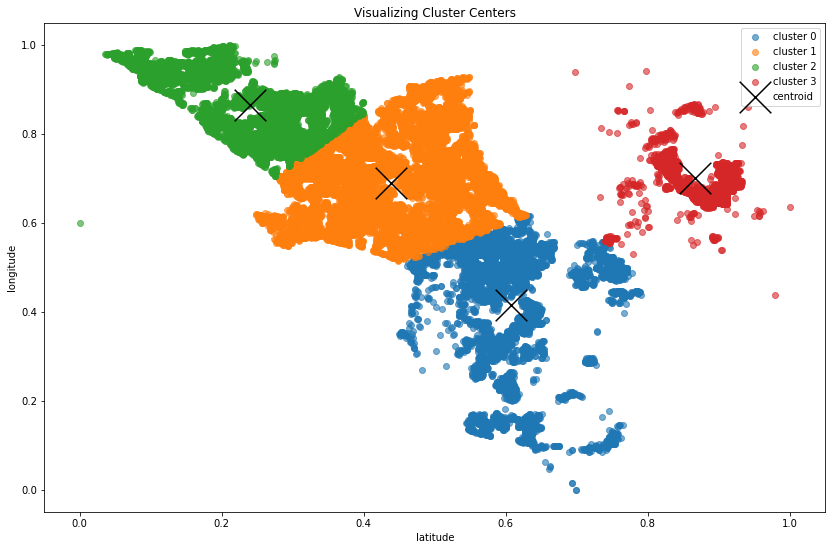

In [27]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_s.groupby('location_cluster'):
    plt.scatter(subset.latitude, subset.longitude, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='longitude', x='latitude', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing Cluster Centers')


Second Cluster
- Using a correlation test
 - $H_0$: There is not a linear relationship between location_cluster and logerror
 - $H_a$: There is a linear relationship between location_cluster and logerror


In [28]:
x = train_s.location_cluster
y = train_s.logerror
α = 0.05
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)
if p < α:
    print("We reject the H0.")
else:
    print("We fail to reject the H0.")

r = 0.00813714389345278
p = 0.16485874638608586
We fail to reject the H0.


Takeaways 
- there is no linear relationship between my location cluster and logerror 

<hr style="border:2px solid gray">

## Third cluster 
- 'Age_size' contains features: 'age' and 'lotsize' 

In [29]:
A = train_s[['lotsizesquarefeet', 'age']]

In [30]:
kmeans2 = KMeans(n_clusters=4)
kmeans2.fit(A)

clusters = kmeans2.predict(A)
clusters

array([0, 1, 2, ..., 1, 2, 2], dtype=int32)

In [31]:
train_s['age_size'] = clusters

In [32]:
kmeans2.cluster_centers_

array([[1.24997980e-02, 4.72437579e+01],
       [1.15769239e-02, 6.54851687e+01],
       [1.60035188e-02, 2.11845292e+01],
       [9.13957851e-03, 9.33958084e+01]])

In [33]:
centroids2 = pd.DataFrame(kmeans2.cluster_centers_, columns=A.columns)


Text(0.5, 1.0, 'Visualizing Cluster Centers')

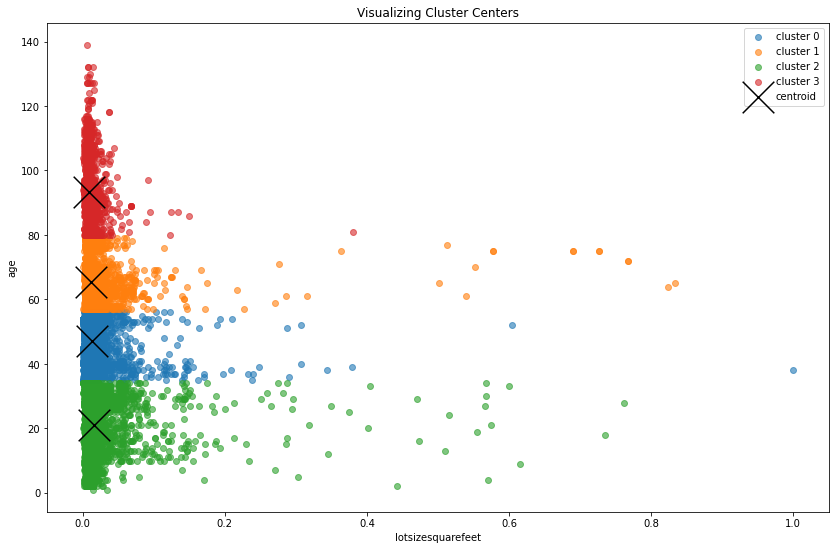

In [34]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_s.groupby('age_size'):
    plt.scatter(subset.lotsizesquarefeet, subset.age, label='cluster ' + str(cluster), alpha=.6)

centroids2.plot.scatter(y='age', x='lotsizesquarefeet', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('lotsizesquarefeet')
plt.ylabel('age')
plt.title('Visualizing Cluster Centers')

Third Cluster
- Using a correlation test
 - $H_0$: There is not a linear relationship between age_size and logerror
 - $H_a$: There is a linear relationship between age_size and logerror

In [35]:
x = train_s.age_size
y = train_s.logerror
α = 0.05
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)
if p < α:
    print("We reject the H0.")
else:
    print("We fail to reject the H0.")

r = -0.010503729348089106
p = 0.07299171078342048
We fail to reject the H0.


Take aways 

- There is no linear correlation between age_size cluster and logerror 

##  Clustering Takeaways 

- There was no linear correlation between any of my clusters and log error, unfortuatly

<hr style="border:2px solid green">

# Modeling

I decided since my custers was not able to show me a relationship between features and log error I decided to use some `Feature Engineering`
- To determine the features that have a relationship with logerror, 4 of the best features where chosen using `Select k best` 


Models Used 


- OLS- (Ordiary Least Squares)

- LassoLars

- GLM- (Generalized Linear Model)

- Polyniomial Model- `This model had the lowest RMSE`

In [36]:
X_train = train_s[['bathroomcnt','bedroomcnt','latitude', 'longitude']]
y_train = pd.DataFrame(train[['logerror']])


X_validate = valid_s[['bathroomcnt','bedroomcnt','latitude', 'longitude']]
y_validate = pd.DataFrame(validate[['logerror']])


X_test = test_s[['bathroomcnt','bedroomcnt','latitude', 'longitude']]
y_test = pd.DataFrame(test[['logerror']])

### The Baseline 

In [37]:
from math import sqrt
from sklearn.metrics import mean_squared_error
#Establish baselines for the train and validation subsets
baseline = train.logerror.mean()

train['baseline'] = baseline
validate['baseline'] = baseline

train_rmse = sqrt(mean_squared_error(train.logerror, train.baseline))
valid_rmse = sqrt(mean_squared_error(validate.logerror, validate.baseline))

print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(valid_rmse))

Train baseline RMSE: 0.17902282261997393.
Validation baseline RMSE: 0.16293244362415202.


### Our end goal for modeling is to find a model that has the lowest RMSE (Root Mean Squared Error) and beat that baseline!

RMSE is an evaluation metric, that will measure "how good a model is" and measure how well a model predicts the target variable, which is the value of a property
In our models, RMSE is already in dollar value, perfect for comparison


<hr style="border:2px solid gray">

### OLS

In [38]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train['logerror'])

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train['logerror'], y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.1788394195711862 
Validation/Out-of-Sample:  0.162695056693868


<hr style="border:2px solid gray">

### Lasso lars

In [39]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train['logerror'])

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train['logerror'], y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.17902282261997393 
Validation/Out-of-Sample:  0.16293244362415202


<hr style="border:2px solid gray">

### GLM Model  

In [40]:
# create the model object
glm = TweedieRegressor(power=0, alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train['logerror'])

# predict train
y_train['logerror_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train['logerror'], y_train.logerror_pred_glm)**(1/2)

# predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate.logerror_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  0.17900766205540333 
Validation/Out-of-Sample:  0.1629154148124571


<hr style="border:2px solid gray">

### Polynomial Model 

In [41]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [42]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train['logerror'])

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train['logerror'], y_train.logerror_pred_lm2)**(1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate.logerror_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.17878117616995837 
Validation/Out-of-Sample:  0.16267885857439796


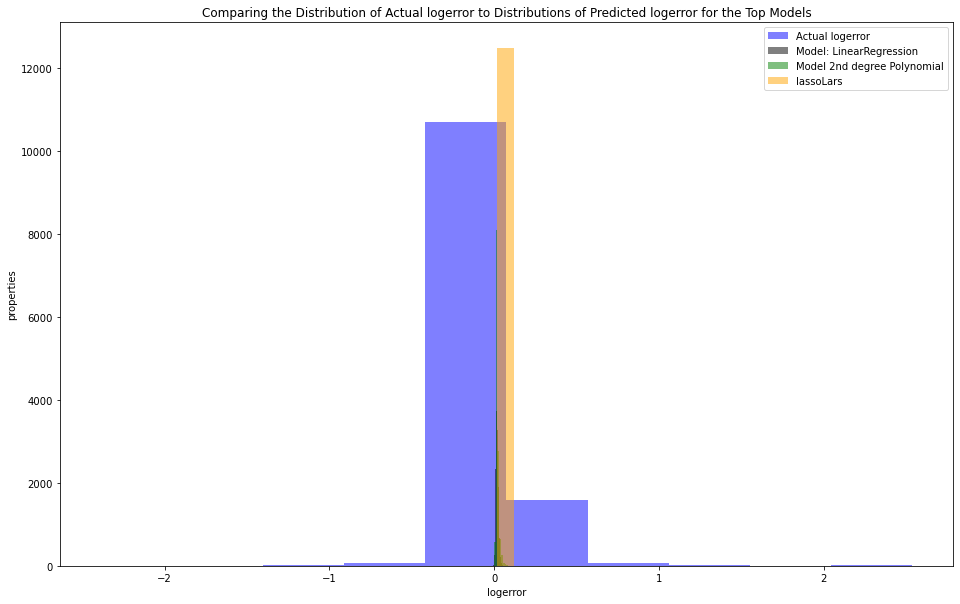

In [45]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,10))
plt.hist(y_validate.logerror, color='blue', alpha=.5, label="Actual logerror")
plt.hist(y_validate.logerror_pred_lm, color='black', alpha=.5, label="Model: LinearRegression")
#plt.hist(y_validate.tax_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.logerror_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.hist(y_validate.logerror_pred_lars, color='orange', alpha=.5, label="lassoLars")
plt.xlabel("logerror")
plt.ylabel("properties")
plt.title("Comparing the Distribution of Actual logerror to Distributions of Predicted logerror for the Top Models")
plt.legend()
plt.show()

Testing the Best model `Ploynomial Model 2nd degree` with the test dataset  

In [44]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['logerror_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm2)**(1/2)

print("RMSE for 2nd Degree Polynomial Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for 2nd Degree Polynomial Model using LinearRegression
Out-of-Sample Performance:  0.17032284824557953


----------------------

`RMSE for Baseline` 

Train baseline RMSE: 0.17902282261997393.

Validation baseline RMSE: 0.16293244362415202

--------------

`RMSE for Polynomial Model, degrees=2`

Training/In-Sample:  0.17878117616995837 

Validation/Out-of-Sample:  0.16267885857439796

Test/Out-of-Sample Performance:  0.17032284824557953

### Takeways
#### - The best model for this Zillow dataset is Ploynomial Model 2nd degree
- The models are not significantly different from the baseline 
- Some are better than the baseline, but by a very small amount 

<hr style="border:2px solid green">

# Conclusion

- From the whole report we can see that some features have a relationsip with log error but those relationsips are to weak to create a great reasonable model.

## Recomendations

- Trying other key drivers of logerror that I was not able to touch on  
- Keep improving the baseline model since it is a very good model to work with
- There is alot of missing data, if there is a way we could revisit those properties or find more meaninful ways to aquire such data to therefore make better predictions with our models 

## Next Steps

- Making different clusters with different features
- Get different approches from my peers 
- Trying different models such as classification models 